# Demonstrate POC Running on Destination Machine

This notebook will port the Milvus DB to a Destination Machine (e.g. Jetson) and demonstrate how to query it on that destination platform.
The POC in this notebook demonstrates the capability using a “separate directory” that simulates the destination computer/device.

The following illustrates the Retrieval Pipeline:

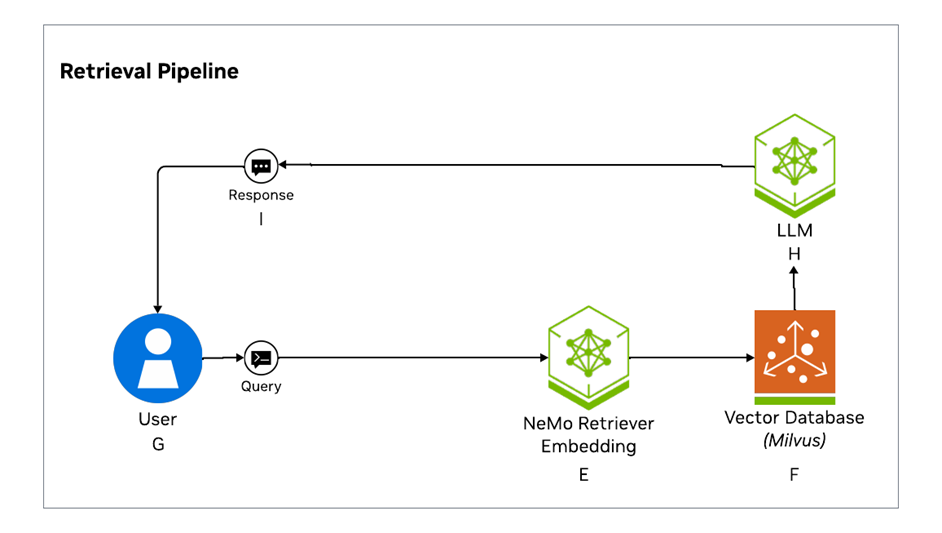

In [1]:
# STEP 1: Export the existing Milvus vector DB with the Pharmacopia document content
from pymilvus import MilvusClient
import json, os
import pandas as pd
import numpy as np

def convert_to_serializable(obj):
    """Convert numpy types to Python native types"""
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, np.float32):
        return float(obj)
    elif isinstance(obj, np.int64):
        return int(obj)
    elif isinstance(obj, (np.bool_, bool)):
        return bool(obj)
    elif isinstance(obj, dict):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_to_serializable(item) for item in obj]
    else:
        return obj

def export_collection():
    """Export your current NV-Ingest collection to a portable file"""
    
    # Connect to the current Milvus instance to explort the DB
    client = MilvusClient(uri="http://localhost:19530")
    collection_name = "nv_ingest_test"
    
    print(f"🔄 Exporting collection '{collection_name}'...")
    
    try:
        # Get collection info
        collections = client.list_collections()
        print(f"📊 Available collections: {collections}")
        
        if collection_name not in collections:
            print(f"❌ Collection '{collection_name}' not found!")
            print("Available collections:", collections)
            return None
            
        # First, get collection stats to see how many records exist
        stats = client.get_collection_stats(collection_name)
        print(f"📊 Collection stats: {stats}")
        
        # Query all data from the collection (with limit)
        print("🔍 Querying all data...")
        results = client.query(
            collection_name=collection_name,
            filter="",  # Empty filter gets all data
            output_fields=["*"],  # Get all fields
            limit=10000  # Set a reasonable limit
        )
        
        print(f"📄 Found {len(results)} records to export")
        
        if len(results) == 0:
            print("⚠️  No data found in collection!")
            return None
        
        # Show sample of what we're exporting
        print(f"📋 Sample record structure:")
        if results:
            sample = results[0]
            print(f"   Keys: {list(sample.keys())}")
            if 'text' in sample:
                text_preview = sample['text'][:100] + "..." if len(sample['text']) > 100 else sample['text']
                print(f"   Text preview: {text_preview}")
        
        # Prepare export data (convert all numpy types to JSON serializable)
        print("🔄 Processing records for export...")
        processed_records = []
        for i, record in enumerate(results):
            if i % 100 == 0:  # Progress indicator
                print(f"   Processing record {i+1}/{len(results)}")
            processed_record = convert_to_serializable(record)
            processed_records.append(processed_record)
        
        export_data = {
            "collection_name": collection_name,
            "record_count": len(processed_records),
            "records": processed_records,
            "export_timestamp": str(pd.Timestamp.now()),
            "source_milvus": "http://localhost:19530"
        }
        
        # Save to file
        output_file = "nv_ingest_export.json"
        with open(output_file, 'w') as f:
            json.dump(export_data, f, indent=2, default=str)
        
        file_size = len(json.dumps(export_data)) / 1024 / 1024  # MB
        print(f"✅ Successfully exported to '{output_file}'")
        print(f"📦 Export file size: {file_size:.2f} MB")
        print(f"📊 Exported {len(results)} records")
        
        return output_file
        
    except Exception as e:
        print(f"❌ Export failed: {e}")
        return None

# Run the export
export_file = export_collection()

if export_file:
    print(f"\n🎉 Step 1 Complete!")
    print(f"✅ Data exported to: {export_file}")
    print(f"📁 File location: {os.path.abspath(export_file)}")
else:
    print(f"\n❌ Step 1 Failed!")
    print(f"Check if you have data in your vector database first.")

/home/asoller/.local/lib/python3.10/site-packages/pymilvus/client/__init__.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


🔄 Exporting collection 'nv_ingest_test'...
📊 Available collections: ['meta', 'nv_ingest_test']
📊 Collection stats: {'row_count': 450}
🔍 Querying all data...
📄 Found 450 records to export
📋 Sample record structure:
   Keys: ['pk', 'vector', 'source', 'content_metadata', 'text']
   Text preview: ����������������
��������������
“Desire to take medicines ... distinguishes man from animals.” —Si...
🔄 Processing records for export...
   Processing record 1/450
   Processing record 101/450
   Processing record 201/450
   Processing record 301/450
   Processing record 401/450
✅ Successfully exported to 'nv_ingest_export.json'
📦 Export file size: 20.43 MB
📊 Exported 450 records

🎉 Step 1 Complete!
✅ Data exported to: nv_ingest_export.json
📁 File location: /mnt/c/Users/asoller/nv-ingest-project/nv-ingest/nv_ingest_export.json


## Port the Milvus DB to the destination computer

In [3]:
# STEP 2: Import exported data to Milvus DB on destination computer (We are simulating this on a laptop for now)
# During this step, the data gets sent toa new Milvus container (on port 19540)
# The Milvus container writes the data to /var/lib/milvus inside the container
# Docker then maps /var/lib/milvus → ./destination_volumes/milvus on the host, simulating a different machine

from pymilvus import MilvusClient
import json
import time

def import_to_destination():
    """Import exported data to the REAL destination Milvus (port 19540)"""
    
    # Load the exported data
    print("📂 Loading exported data...")
    with open('nv_ingest_export.json', 'r') as f:
        export_data = json.load(f)
    
    original_collection = export_data["collection_name"]
    records = export_data["records"]
    
    print(f"📊 Loaded {len(records)} records from export")
    print(f"🎯 Original collection: {original_collection}")
    
    # Connect to destination Milvus (Separate instance on port 19540, simulating the destination machine)
    destination_milvus_uri = "http://localhost:19540" 
    destination_collection = "nv_ingest_test"  # Same name for simplicity
    
    print(f"🔗 Connecting to destination Milvus: {destination_milvus_uri}")
    
    # Retry connection logic (containers might still be starting)
    max_retries = 5
    for attempt in range(max_retries):
        try:
            client = MilvusClient(uri=destination_milvus_uri)
            collections = client.list_collections()
            print(f"✅ Connected to destination! Attempt {attempt + 1}")
            print(f"📊 Existing collections on destination: {collections}")
            break
        except Exception as e:
            if attempt < max_retries - 1:
                print(f"⏳ Connection attempt {attempt + 1} failed, retrying in 10 seconds...")
                print(f"   Error: {e}")
                time.sleep(10)
            else:
                print(f"❌ Cannot connect to destination Milvus after {max_retries} attempts: {e}")
                print("💡 Make sure destination containers are running:")
                print("   docker-compose -f docker-compose.destination.yml up -d")
                return False
    
    # Create the destination collection
    print(f"🔧 Creating destination collection '{destination_collection}'...")
    try:
        # Check if collection exists first
        collections = client.list_collections()
        if destination_collection in collections:
            print(f"🗑️  Dropping existing destination collection '{destination_collection}'")
            client.drop_collection(destination_collection)
        
        # Create new collection with same schema as original
        client.create_collection(
            collection_name=destination_collection,
            dimension=2048,  # Vector dimension from NV-Ingest
            metric_type="COSINE",  # Similarity metric
            primary_field_name="pk",
            vector_field_name="vector"
        )
        print(f"✅ Destination collection '{destination_collection}' created successfully")
        
    except Exception as e:
        print(f"❌ Destination collection creation failed: {e}")
        return False
    
    # Import data in batches
    batch_size = 100
    total_batches = (len(records) + batch_size - 1) // batch_size
    
    print(f"📤 Importing {len(records)} records to destination in {total_batches} batches...")
    
    imported_count = 0
    for i in range(0, len(records), batch_size):
        batch = records[i:i + batch_size]
        batch_num = (i // batch_size) + 1
        
        try:
            client.insert(
                collection_name=destination_collection,
                data=batch
            )
            imported_count += len(batch)
            print(f"✅ Batch {batch_num}/{total_batches}: imported {len(batch)} records")
            
        except Exception as e:
            print(f"❌ Batch {batch_num} failed: {e}")
            break
    
    print(f"\n🎉 Destination transfer completed!")
    print(f"📊 Successfully imported: {imported_count}/{len(records)} records")
    
    # Verify the destination import
    print(f"🔍 Verifying destination import...")
    try:
        stats = client.get_collection_stats(destination_collection)
        print(f"📈 Destination collection stats: {stats}")
        
        # Test a query on destination
        test_results = client.query(
            collection_name=destination_collection,
            filter="",
            output_fields=["text"],
            limit=1
        )
        
        if test_results:
            print(f"✅ Destination verification successful!")
            sample_text = test_results[0]['text'][:100] + "..." if len(test_results[0]['text']) > 100 else test_results[0]['text']
            print(f"📄 Sample text from destination: {sample_text}")
        else:
            print(f"⚠️  No data found in destination verification query")
            
    except Exception as e:
        print(f"❌ Destination verification failed: {e}")
    
    return imported_count > 0

# Run the import
success = import_to_destination()

if success:
    print(f"\n🎉 Step 2 Complete!")
    print(f"✅ Data successfully imported to REAL destination Milvus")
    print(f"🔗 Destination endpoint: http://localhost:19540")
    print(f"💡 This is a real separate Milvus instance (like on a Jetson)")
else:
    print(f"\n❌ Step 2 Failed!")
    print(f"Check destination container health and try again")

📂 Loading exported data...
📊 Loaded 450 records from export
🎯 Original collection: nv_ingest_test
🔗 Connecting to destination Milvus: http://localhost:19540
✅ Connected to destination! Attempt 1
📊 Existing collections on destination: ['nv_ingest_test']
🔧 Creating destination collection 'nv_ingest_test'...
🗑️  Dropping existing destination collection 'nv_ingest_test'
✅ Destination collection 'nv_ingest_test' created successfully
📤 Importing 450 records to destination in 5 batches...
✅ Batch 1/5: imported 100 records
✅ Batch 2/5: imported 100 records
✅ Batch 3/5: imported 100 records
✅ Batch 4/5: imported 100 records
✅ Batch 5/5: imported 50 records

🎉 Destination transfer completed!
📊 Successfully imported: 450/450 records
🔍 Verifying destination import...
📈 Destination collection stats: {'row_count': 0}
⚠️  No data found in destination verification query

🎉 Step 2 Complete!
✅ Data successfully imported to REAL destination Milvus
🔗 Destination endpoint: http://localhost:19540
💡 This is 

In [4]:
# This cell demonstrates a lightweight RAG System running on destination computer (e.g., a simulated Jetson)

import requests
import json
import os
from pymilvus import MilvusClient
from openai import OpenAI

class LightweightRAG:
    def __init__(self, milvus_uri, collection_name, nvidia_api_key):
        self.milvus_uri = milvus_uri
        self.collection_name = collection_name
        self.nvidia_api_key = nvidia_api_key
        
        print(f"🔗 Connecting to Milvus: {milvus_uri}")
        print(f"📊 Using collection: {collection_name}")
        
        # Initialize Milvus client for destination
        self.milvus_client = MilvusClient(uri=milvus_uri)
        
        # Initialize OpenAI client for NVIDIA LLM  
        self.llm_client = OpenAI(
            base_url="https://integrate.api.nvidia.com/v1",
            api_key=nvidia_api_key
        )
        
        # Test the connection to make sure that Milvus is reachable and responding
        try:
            collections = self.milvus_client.list_collections()
            if collection_name in collections:
                print(f"✅ Connected! Collection '{collection_name}' found")
            else:
                print(f"❌ Collection '{collection_name}' not found!")
                print(f"Available collections: {collections}")
        except Exception as e:
            print(f"❌ Connection failed: {e}")
    
    #This function converts the input query into a vector embedding using the same embedding model that was used for the ingest process
    def embed_text_direct(self, text):
        """
        Call NVIDIA embedding API directly (no NV-Ingest needed)
        Uses the same model as your ingested documents
        """
        print(f"🧠 Embedding text: '{text[:50]}...'")
        
        url = "https://integrate.api.nvidia.com/v1/embeddings"
        
        headers = {
            "Authorization": f"Bearer {self.nvidia_api_key}",
            "Content-Type": "application/json"
        }
        
        payload = {
            "model": "nvidia/llama-3.2-nv-embedqa-1b-v2",  # Same model as ingestion
            "input": text,
            "encoding_format": "float",
            "input_type": "query"
        }
        
        response = requests.post(url, headers=headers, json=payload)
        
        if response.status_code == 200:
            result = response.json()
            embedding = result["data"][0]["embedding"]
            print(f"✅ Embedding generated ({len(embedding)} dimensions)")
            return embedding
        else:
            print(f"❌ Embedding API error: {response.status_code}")
            print(f"Response: {response.text}")
            raise Exception(f"Embedding API error: {response.status_code} - {response.text}")
    
    # This next function searches the destination Milvus database to find the most relevant document chunks based on vector similarity.
    # First, it takes the query embedding (2048-number vector from embed_text_direct())
    # Then, it searches the destination Milvus collection (nv_ingest_test on port 19540)
    # We find the top-k most similar documents (default top 3) using cosine similarity
    # We then return matching document chunks with their similarity scores and text content
    def search_similar_docs(self, query_embedding, top_k=3):
        """Search destination Milvus for similar document chunks"""
        
        try:
            search_results = self.milvus_client.search(
                collection_name=self.collection_name,
                data=[query_embedding],  # Query vector
                limit=top_k,
                output_fields=["text", "source", "pk"]  # Fields to return
            )
            
            results = search_results[0]  # First (and only) query results
            
            # Show similarity scores
            for i, result in enumerate(results):
                score = result.get('distance', 'N/A')
                text_preview = result['entity']['text'][:100] + "..." if len(result['entity']['text']) > 100 else result['entity']['text']
                print(f"   {i+1}. Score: {score:.3f} - {text_preview}")
            
            return results
            
        except Exception as e:
            print(f"❌ Search failed: {e}")
            return []
    
    def generate_answer(self, user_query, context_chunks):
        """Generate answer using retrieved context and NVIDIA LLM"""
        
        if not context_chunks:
            return "No relevant information found in the documents."
        
        print(f"🤖 Generating answer with {len(context_chunks)} context chunks...")
        
        # Combine retrieved chunks into context
        context_texts = []
        for chunk in context_chunks:
            text = chunk['entity']['text']
            # Clean up any encoding issues
            clean_text = text.encode('utf-8', errors='ignore').decode('utf-8')
            context_texts.append(clean_text)
        
        context = "\n\n".join(context_texts)
        
        prompt = f"""Using only the following context from documents, answer the user's question. If the answer cannot be found in the context, say so.

Context:
{context}

Question: {user_query}

Answer based only on the provided context:"""
        
        try:
            completion = self.llm_client.chat.completions.create(
                model="nvidia/llama-3.1-nemotron-70b-instruct",
                messages=[{"role": "user", "content": prompt}],
                max_tokens=500,
                temperature=0.1  # Low temperature for factual responses
            )
            
            answer = completion.choices[0].message.content
            print(f"✅ Answer generated successfully")
            return answer
            
        except Exception as e:
            print(f"❌ Answer generation failed: {e}")
            return f"Error generating answer: {e}"

    # This next function orchestrates the complete RAG pipeline on the destination computer to answer user questions
    # It takes as input a natural language question and runs the 3-step RAG pipeline:
    #Step 1: embed_text_direct() → Convert question to vector
    #Step 2: search_similar_docs() → Find relevant chunks
    #Step 3: generate_answer() → Use LLM to create final answer. 
    # We return a comprehensive answer based only on the retrieved pharmacopia content for this POC
    def answer_question(self, user_query):
        """Complete RAG pipeline: Embed → Search → Generate"""
        
        print(f"\n" + "="*60)
        print(f"🎯 RAG QUERY: {user_query}")
        print(f"="*60)
        
        try:
            # Step 1: Embed the user query directly
            query_embedding = self.embed_text_direct(user_query)
            
            # Step 2: Search for similar documents
            similar_docs = self.search_similar_docs(query_embedding, top_k=3)
            
            # Step 3: Generate answer
            answer = self.generate_answer(user_query, similar_docs)
            
            return answer
            
        except Exception as e:
            return f"RAG pipeline error: {e}"

# USAGE - Test the lightweight RAG system
def test_lightweight_rag():
    """Test the lightweight RAG system with destination Milvus"""
    
    # Initialize lightweight RAG system (using destination Milvus)
    rag = LightweightRAG(
        milvus_uri="http://localhost:19540",  # Destination Milvus port
        collection_name="nv_ingest_test", 
        nvidia_api_key=os.environ["NVIDIA_BUILD_API_KEY"]
    )
    
    # Test queries
    test_queries = [
        "List the options for local anesthetics that can be applied without risk of paralysis or cardiac arrest. Use only the data from the pharmacopia manual. Elaborate on the usage of each drug."
    ]
    
    for query in test_queries:
        answer = rag.answer_question(query)
        print(f"\n🤖 ANSWER: {answer}")
        print(f"\n" + "-"*60)

# Run the test
print("🚀 Testing Lightweight RAG System...")
test_lightweight_rag()

print(f"✅ Lightweight RAG system on destination computer working!")
print(f"📍 Querying destination Milvus on port 19540")

🚀 Testing Lightweight RAG System...
🔗 Connecting to Milvus: http://localhost:19540
📊 Using collection: nv_ingest_test
✅ Connected! Collection 'nv_ingest_test' found

🎯 RAG QUERY: List the options for local anesthetics that can be applied without risk of paralysis or cardiac arrest. Use only the data from the pharmacopia manual. Elaborate on the usage of each drug.
🧠 Embedding text: 'List the options for local anesthetics that can be...'
✅ Embedding generated (2048 dimensions)
   1. Score: 0.518 - 24 ANESTHESIA: Neuromuscular Blockade Reversal Agents
BUPIVACAINE LIPOSOME ( EXPAREL ) � L – ♀ C 
...
   2. Score: 0.460 - ANESTHESIA: Local Anesthetics 23
of 20 mg PO, IM route 0.1 to 0.15 mg/kg IM. 
IV route initial dos...
   3. Score: 0.378 - APPENDIX
ADULT EMERGENCY DRUGS (selected)
ALLERGY
diphenhydramine (Benadryl): 25 to 50 mg IV/IM/P...
🤖 Generating answer with 3 context chunks...
✅ Answer generated successfully

🤖 ANSWER: Based on the provided pharmacopia manual, here are the options 